In [42]:
#import packages
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import hamming_loss,f1_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler

In [43]:
# read in data from csv, and prepare for training
# we drop features that were determined insignificant from the feature selection process.
df=pd.read_csv('wind_dataset.csv')
state=df["State"]
name=df["Name"]
df.drop(["State","Name","Surface_Albedo","Precipitable_Water","GHI"], axis=1, inplace=True) 
order_of_df = df.index #store for later
df=df.sample(frac=1)  #I CAN do the fraction but it lowers a bit but i think thats good its not neccisarily a bad thing model with 80 
# percent accuracy are not atrocious 

In [44]:
#preparing functions
def prepare_semi_supervised_data(data_frame, count):
    final_features = ["Temperature", "Wind_Speed", "Relative_Humidity", "Pressure"]
    features = data_frame[final_features]
    labels = data_frame.iloc[:, -1]
    

    

    labeled_indices = (labels == 0) | (labels == 1) #boolean mask 
    unlabeled = labels == -1
    X_labeled = features[labeled_indices]
    y_labeled = labels[labeled_indices] 
    X_unknown = features[unlabeled].iloc[:100, :]

    #we ignore -2 because we are not confident in those predictions

    return X_labeled, y_labeled, X_unknown

def add_pseudo_label_proba(df, probs, prob_threshold=0.6):  #play aroud with value to not have too many -2's  or maybe it can be a user thing
    i = 0

    while i < df.shape[0] and len(probs) != 0:
        if df.loc[i, "Suitability"] == -1:
            predicted_class = np.argmax(probs[0])

            if probs[0][predicted_class] >= prob_threshold:
                df.loc[i, "Suitability"] = predicted_class
            else:
                df.loc[i, "Suitability"] = -2 #lost causes labeled -2 because they are useless 
                

            probs = probs[1:]
        i += 1

def plot_iterations_scores(f1_scores, accuracy_scores):
    iterations = range(1, len(f1_scores) + 1)

    plt.figure(figsize=(10, 6))  
    plt.plot(iterations, f1_scores, marker='o', linestyle='-', label='F1-Score')
    plt.plot(iterations, accuracy_scores, marker='s', linestyle='-', label='Accuracy')

    plt.xlabel("Iterations")
    plt.ylabel("Score")
    plt.title("F1-Score and Accuracy vs. Iterations for the Wind RFC Model")
    plt.ylim(0.5, 1)
    plt.grid(True)
    plt.legend()
    
    plt.show()

In [45]:
#preperation dictionaries
results_dic = {
    'Accuracy': [],
    'F1-Score': [],
    'Hamming Loss': []
}

params = {
    'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_leaf_nodes': 27, 'criterion': 'gini',
    'max_depth': 5
}


In [46]:
#loop
count = 0


while count < 10:   #10th iteration will be with all data trained 
    model = RandomForestClassifier(**params)
    X_labeled, y_labeled, X_unknown = prepare_semi_supervised_data(df, count)

    X_train_labeled, X_test, y_train_labeled, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, shuffle=True)

    model.fit(X_train_labeled, y_train_labeled)

    prob_predictions = model.predict_proba(X_test)

    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, np.argmax(prob_predictions, axis=1)) 
    hamming_loss_value = hamming_loss(y_test, np.argmax(prob_predictions, axis=1))

    result = {
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Hamming Loss': hamming_loss_value
    }
    results_dic["Accuracy"].append(accuracy)
    results_dic["F1-Score"].append(f1)
    results_dic["Hamming Loss"].append(hamming_loss_value)

    if len(X_unknown) > 0:
        prob_labels = model.predict_proba(X_unknown)
        add_pseudo_label_proba(df, prob_labels)

    count += 1

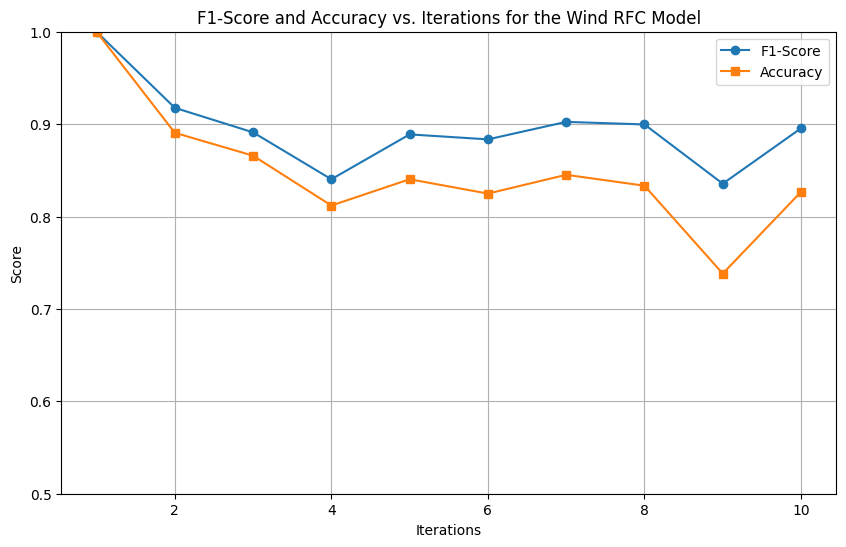

Accuracy list: [1.0, 0.890625, 0.8658536585365854, 0.8118811881188119, 0.8403361344537815, 0.8248175182481752, 0.8451612903225807, 0.8333333333333334, 0.7382198952879581, 0.8267326732673267]
0.8954598044186332


In [47]:
#plotting and exporting



plot_iterations_scores(results_dic["F1-Score"],results_dic["Accuracy"])

df.insert(0, "Name", name)
df.insert(0, "State", state)
# Assuming df is the shuffled DataFrame
restored_order_df = df.loc[order_of_df].reset_index(drop=True)

restored_order_df.to_csv("Labeled_Wind.csv", index=False)  #this is how i restore it ?

print(f"Accuracy list: {results_dic['Accuracy']}")

print(np.mean(results_dic["F1-Score"]))
